Classes: ['jassid', 'looper', 'rsc', 'thrips']
Epoch [1/10], Train Loss: 1.6567, Train Acc: 25.47%, Val Loss: 1.3998, Val Acc: 24.38%
Epoch [2/10], Train Loss: 1.4139, Train Acc: 25.39%, Val Loss: 1.4257, Val Acc: 23.44%
Epoch [3/10], Train Loss: 1.4297, Train Acc: 23.44%, Val Loss: 1.3979, Val Acc: 24.38%
Epoch [4/10], Train Loss: 1.4071, Train Acc: 27.50%, Val Loss: 1.4036, Val Acc: 24.38%
Epoch [5/10], Train Loss: 1.3950, Train Acc: 26.33%, Val Loss: 1.4311, Val Acc: 24.38%
Epoch [6/10], Train Loss: 1.4147, Train Acc: 26.33%, Val Loss: 1.3953, Val Acc: 27.81%
Epoch [7/10], Train Loss: 1.4152, Train Acc: 26.25%, Val Loss: 1.4392, Val Acc: 23.44%
Epoch [8/10], Train Loss: 1.4524, Train Acc: 24.69%, Val Loss: 1.4048, Val Acc: 23.44%
Epoch [9/10], Train Loss: 1.4084, Train Acc: 25.39%, Val Loss: 1.3846, Val Acc: 27.81%
Epoch [10/10], Train Loss: 1.4032, Train Acc: 25.55%, Val Loss: 1.4050, Val Acc: 23.44%


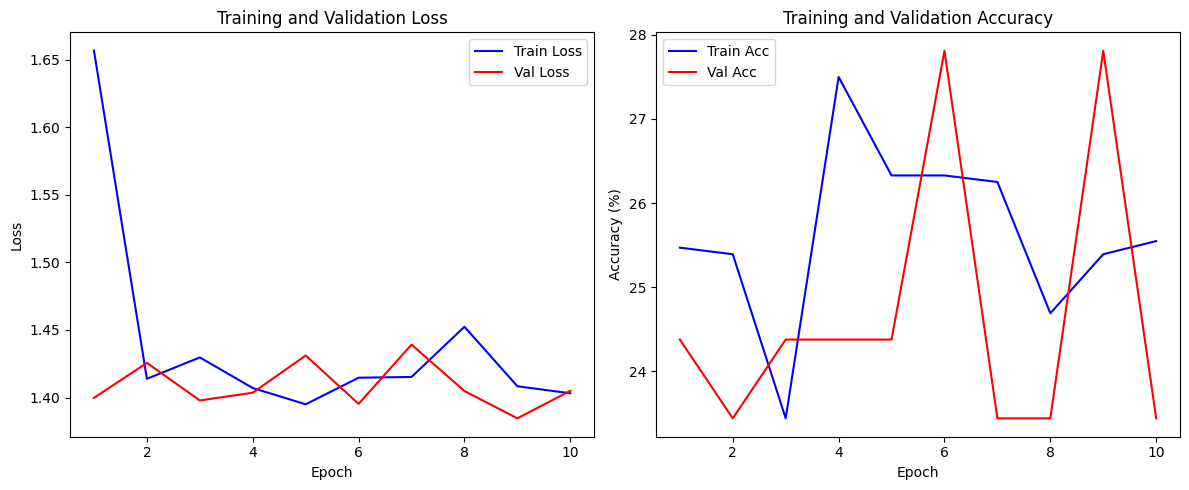

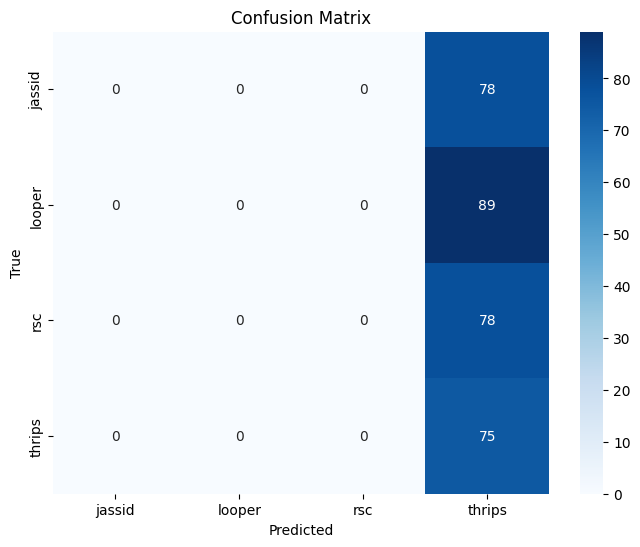


Classification Report:
              precision    recall  f1-score   support

      jassid       0.00      0.00      0.00        78
      looper       0.00      0.00      0.00        89
         rsc       0.00      0.00      0.00        78
      thrips       0.23      1.00      0.38        75

    accuracy                           0.23       320
   macro avg       0.06      0.25      0.09       320
weighted avg       0.05      0.23      0.09       320



/home/idrone2/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/idrone2/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/idrone2/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


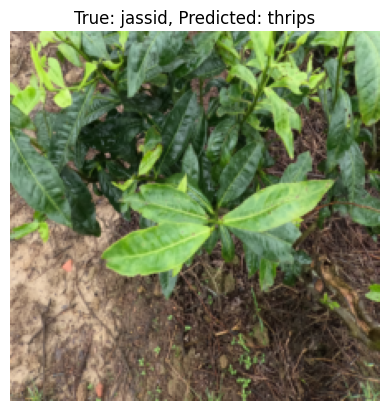

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

# Patch Embedding Layer (same as before)
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=384):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        return x

# Transformer Block (same as before)
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=384, num_heads=6, mlp_dim=768, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x2 = self.norm1(x)
        attn_output, _ = self.attn(x2, x2, x2)
        x = x + attn_output
        x2 = self.norm2(x)
        x = x + self.mlp(x2)
        return x

# Lightweight Vision Transformer (same as before)
class LightweightViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=4, 
                 embed_dim=384, depth=6, num_heads=6, mlp_dim=768, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.transformer = nn.ModuleList([TransformerBlock(embed_dim, num_heads, mlp_dim, dropout) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        x = self.patch_embed(x)
        for block in self.transformer:
            x = block(x)
        x = self.norm(x[:, 0])
        x = self.head(x)
        return x

# Data Loading and Preprocessing
def load_data(data_dir):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    train_size = int(0.8 * len(dataset))  # 80% train, 20% validation
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    return train_loader, val_loader, dataset.classes

# Training Function
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    return train_losses, val_losses, train_accs, val_accs, all_preds, all_labels

# Plotting Functions
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Acc')
    plt.plot(epochs, val_accs, 'r-', label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, all_preds, class_names):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Prediction on Random Image
def predict_random_image(model, dataset, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    image = image.squeeze().cpu().permute(1, 2, 0).numpy()  # Convert to HWC for plotting
    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
    
    plt.imshow(image)
    plt.title(f"True: {class_names[label]}, Predicted: {class_names[predicted.item()]}")
    plt.axis('off')
    plt.show()

# Main Execution
def main():
    # Replace with your dataset path
    data_dir = "/home/idrone2/Desktop/tea_4_cls"  # e.g., "dataset/class1", "dataset/class2", etc.
    
    # Load data
    train_loader, val_loader, class_names = load_data(data_dir)
    print(f"Classes: {class_names}")
    
    # Initialize model
    model = LightweightViT(num_classes=4)
    
    # Train model
    train_losses, val_losses, train_accs, val_accs, all_preds, all_labels = train_model(model, train_loader, val_loader, num_epochs=10)
    
    # Plot training/validation metrics
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
    
    # Confusion Matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Predict on a random image
    full_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))
    predict_random_image(model, full_dataset, class_names)

if __name__ == "__main__":
    main()

Classes: ['jassid', 'looper', 'rsc', 'thrips']
Epoch [1/20], Train Loss: 1.5685, Train Acc: 25.31%, Val Loss: 1.4577, Val Acc: 25.62%
Epoch [2/20], Train Loss: 1.4365, Train Acc: 25.31%, Val Loss: 1.4108, Val Acc: 23.75%
Epoch [3/20], Train Loss: 1.4417, Train Acc: 25.39%, Val Loss: 1.4839, Val Acc: 25.94%
Epoch [4/20], Train Loss: 1.4302, Train Acc: 23.67%, Val Loss: 1.3957, Val Acc: 23.75%
Epoch [5/20], Train Loss: 1.4022, Train Acc: 24.77%, Val Loss: 1.3891, Val Acc: 24.69%
Epoch [6/20], Train Loss: 1.3928, Train Acc: 23.98%, Val Loss: 1.3866, Val Acc: 25.62%
Epoch [7/20], Train Loss: 1.3902, Train Acc: 24.69%, Val Loss: 1.3870, Val Acc: 23.75%
Epoch [8/20], Train Loss: 1.3900, Train Acc: 24.53%, Val Loss: 1.3858, Val Acc: 25.94%
Epoch [9/20], Train Loss: 1.3908, Train Acc: 24.45%, Val Loss: 1.3870, Val Acc: 25.94%
Epoch [10/20], Train Loss: 1.3899, Train Acc: 25.31%, Val Loss: 1.3861, Val Acc: 25.62%
Epoch [11/20], Train Loss: 1.3868, Train Acc: 25.47%, Val Loss: 1.3862, Val Acc: 2

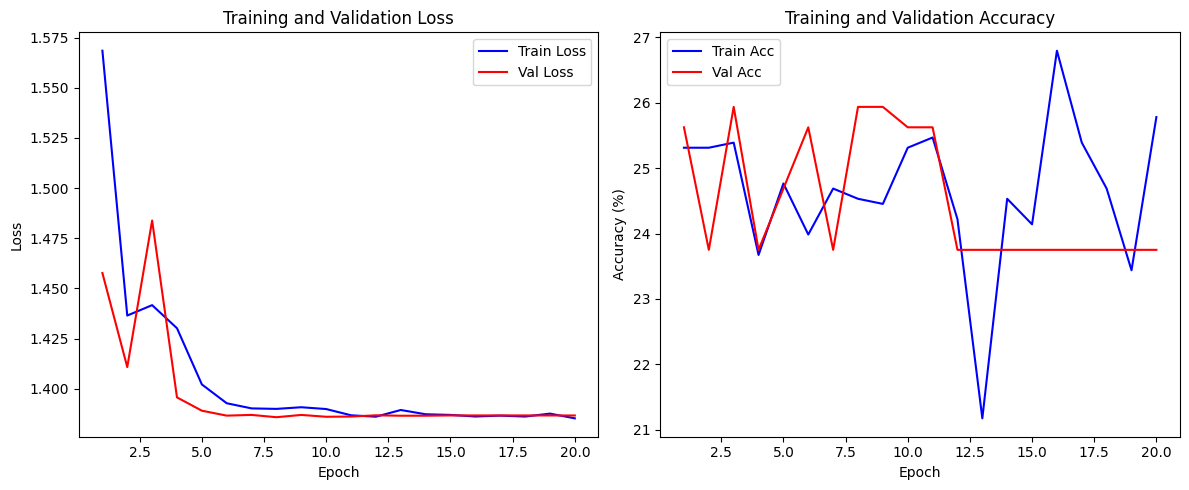

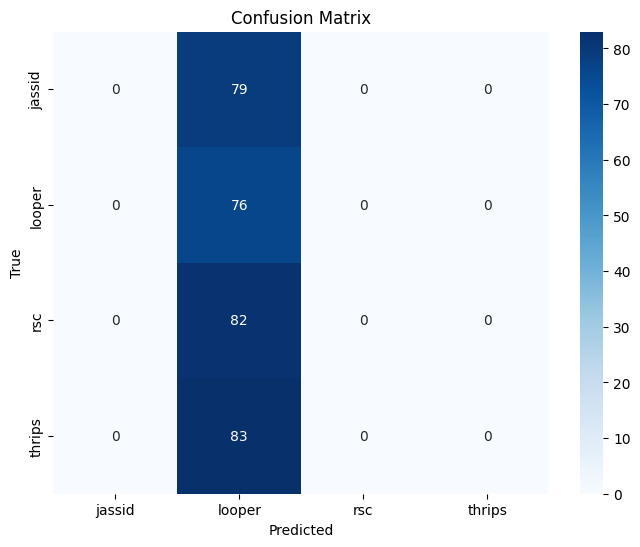


Classification Report:
              precision    recall  f1-score   support

      jassid       0.00      0.00      0.00        79
      looper       0.24      1.00      0.38        76
         rsc       0.00      0.00      0.00        82
      thrips       0.00      0.00      0.00        83

    accuracy                           0.24       320
   macro avg       0.06      0.25      0.10       320
weighted avg       0.06      0.24      0.09       320



/home/idrone2/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/idrone2/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/idrone2/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


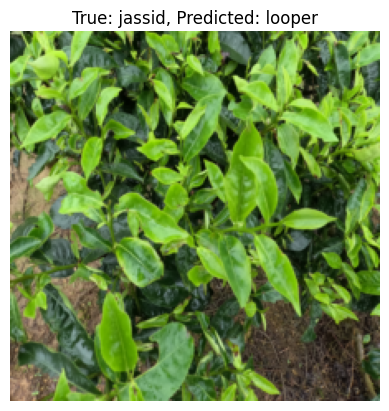

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

# Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=512):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, mlp_dim=1024, dropout=0.2):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x2 = self.norm1(x)
        attn_output, _ = self.attn(x2, x2, x2)
        x = x + attn_output
        x2 = self.norm2(x)
        x = x + self.mlp(x2)
        return x

# Lightweight Vision Transformer
class LightweightViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=4, 
                 embed_dim=512, depth=8, num_heads=8, mlp_dim=1024, dropout=0.2):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.transformer = nn.ModuleList([TransformerBlock(embed_dim, num_heads, mlp_dim, dropout) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        x = self.patch_embed(x)
        for block in self.transformer:
            x = block(x)
        x = self.norm(x[:, 0])
        x = self.head(x)
        return x

# Data Loading and Preprocessing
def load_data(data_dir):
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=train_transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    val_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    return train_loader, val_loader, dataset.classes

# Training Function
def train_model(model, train_loader, val_loader, num_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    return train_losses, val_losses, train_accs, val_accs, all_preds, all_labels

# Plotting Functions
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Acc')
    plt.plot(epochs, val_accs, 'r-', label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, all_preds, class_names):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Prediction on Random Image
def predict_random_image(model, dataset, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    image = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    image = image.squeeze().cpu().permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
    
    plt.imshow(image)
    plt.title(f"True: {class_names[label]}, Predicted: {class_names[predicted.item()]}")
    plt.axis('off')
    plt.show()

# Main Execution
def main():
    # Replace with your dataset path
    data_dir = "/home/idrone2/Desktop/tea_4_cls"  # e.g., "dataset/jassid", "dataset/looper", etc.
    
    # Load data
    train_loader, val_loader, class_names = load_data(data_dir)
    print(f"Classes: {class_names}")
    
    # Initialize model
    model = LightweightViT(num_classes=4)
    
    # Train model
    train_losses, val_losses, train_accs, val_accs, all_preds, all_labels = train_model(model, train_loader, val_loader, num_epochs=20)
    
    # Plot training/validation metrics
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
    
    # Confusion Matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Predict on a random image
    full_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))
    predict_random_image(model, full_dataset, class_names)

if __name__ == "__main__":
    main()

# Darknet50

Classes: ['jassid', 'looper', 'rsc', 'thrips']
Epoch [1/100], Train Loss: 1.5012, Train Acc: 36.72%, Val Loss: 3.4668, Val Acc: 42.19%
Epoch [2/100], Train Loss: 1.3359, Train Acc: 42.19%, Val Loss: 1.3294, Val Acc: 39.06%
Epoch [3/100], Train Loss: 1.3521, Train Acc: 43.67%, Val Loss: 2.7901, Val Acc: 37.19%
Epoch [4/100], Train Loss: 1.2720, Train Acc: 45.70%, Val Loss: 1.3788, Val Acc: 48.12%
Epoch [5/100], Train Loss: 1.2326, Train Acc: 47.42%, Val Loss: 1.3012, Val Acc: 49.06%
Epoch [6/100], Train Loss: 1.1468, Train Acc: 50.08%, Val Loss: 1.1440, Val Acc: 54.69%
Epoch [7/100], Train Loss: 1.1143, Train Acc: 51.09%, Val Loss: 1.1269, Val Acc: 53.44%
Epoch [8/100], Train Loss: 1.1149, Train Acc: 52.19%, Val Loss: 1.1401, Val Acc: 49.38%
Epoch [9/100], Train Loss: 1.1001, Train Acc: 52.03%, Val Loss: 1.1284, Val Acc: 50.00%
Epoch [10/100], Train Loss: 1.0836, Train Acc: 53.75%, Val Loss: 1.1109, Val Acc: 53.44%
Epoch [11/100], Train Loss: 1.0617, Train Acc: 55.08%, Val Loss: 1.1133,

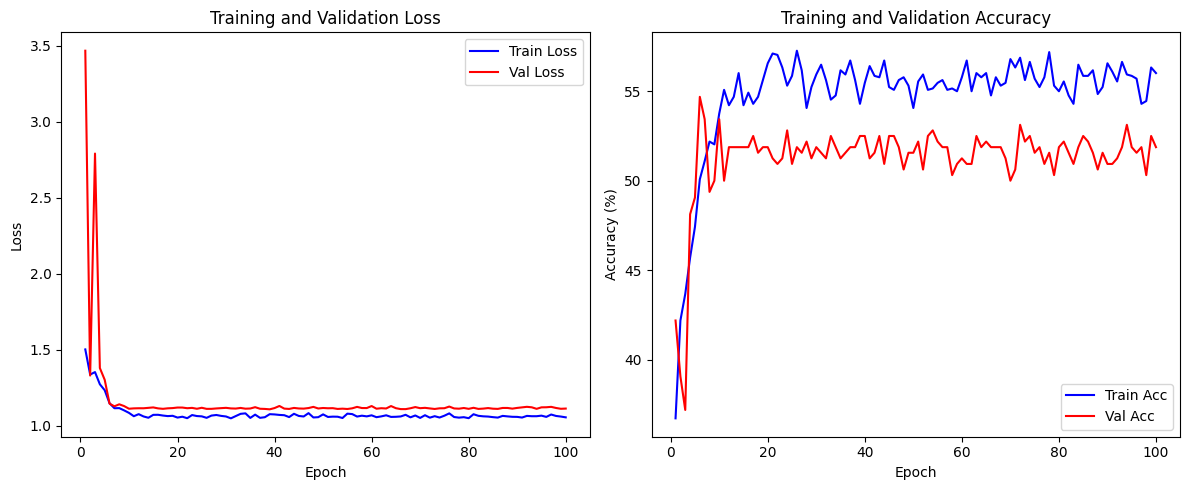

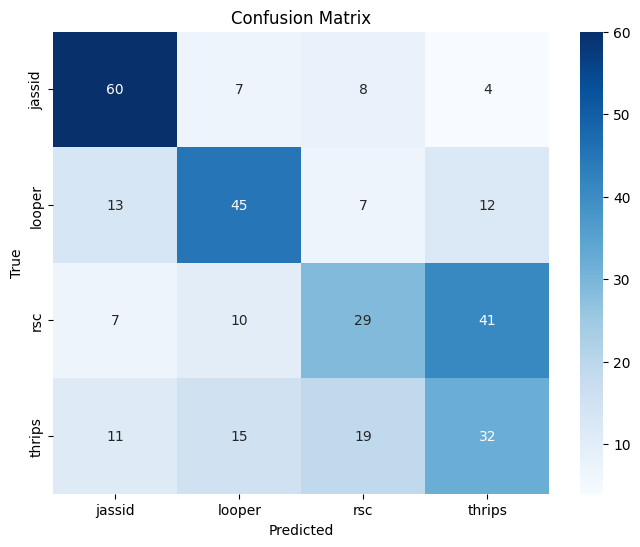


Classification Report:
              precision    recall  f1-score   support

      jassid       0.66      0.76      0.71        79
      looper       0.58      0.58      0.58        77
         rsc       0.46      0.33      0.39        87
      thrips       0.36      0.42      0.39        77

    accuracy                           0.52       320
   macro avg       0.52      0.52      0.52       320
weighted avg       0.52      0.52      0.51       320



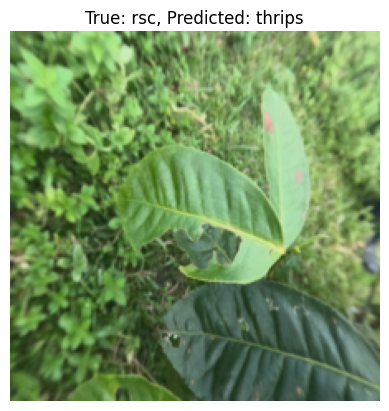

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

# Darknet-50 Residual Block
class DarknetBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels // 2)
        self.conv2 = nn.Conv2d(in_channels // 2, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.leaky_relu = nn.LeakyReLU(0.1, inplace=True)
        
    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        return x + residual

# Darknet-50 Model
class Darknet50(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.leaky_relu = nn.LeakyReLU(0.1, inplace=True)
        
        # Define Darknet layers (approximating Darknet-50 structure)
        self.layers = nn.ModuleList([
            # Stage 1: 32 -> 64
            self._make_layer(32, 64, num_blocks=1),
            # Stage 2: 64 -> 128
            self._make_layer(64, 128, num_blocks=2),
            # Stage 3: 128 -> 256
            self._make_layer(128, 256, num_blocks=8),
            # Stage 4: 256 -> 512
            self._make_layer(256, 512, num_blocks=8),
            # Stage 5: 512 -> 1024
            self._make_layer(512, 1024, num_blocks=4)
        ])
        
        # Global Average Pooling and Classification Head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)
        
    def _make_layer(self, in_channels, out_channels, num_blocks):
        layers = []
        # Downsample
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.1, inplace=True))
        # Residual blocks
        for _ in range(num_blocks):
            layers.append(DarknetBlock(out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        
        for layer in self.layers:
            x = layer(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Data Loading and Preprocessing
def load_data(data_dir):
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=train_transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    val_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    return train_loader, val_loader, dataset.classes

# Training Function
def train_model(model, train_loader, val_loader, num_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    return train_losses, val_losses, train_accs, val_accs, all_preds, all_labels

# Plotting Functions
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Acc')
    plt.plot(epochs, val_accs, 'r-', label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, all_preds, class_names):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Prediction on Random Image
def predict_random_image(model, dataset, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    image = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    image = image.squeeze().cpu().permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
    
    plt.imshow(image)
    plt.title(f"True: {class_names[label]}, Predicted: {class_names[predicted.item()]}")
    plt.axis('off')
    plt.show()

# Main Execution
def main():
    # Replace with your dataset path
    data_dir = "/home/idrone2/Desktop/Camellia/tea_4_cls"  # e.g., "dataset/jassid", "dataset/looper", etc.
    
    # Load data
    train_loader, val_loader, class_names = load_data(data_dir)
    print(f"Classes: {class_names}")
    
    # Initialize model
    model = Darknet50(num_classes=4)
    
    # Train model
    train_losses, val_losses, train_accs, val_accs, all_preds, all_labels = train_model(model, train_loader, val_loader, num_epochs=100)
    
    # Plot training/validation metrics
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
    
    # Confusion Matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Predict on a random image
    full_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))
    predict_random_image(model, full_dataset, class_names)

if __name__ == "__main__":
    main()

Classes: ['jassid', 'looper', 'rsc', 'thrips']


/home/idrone2/.local/lib/python3.11/site-packages/torch/utils/checkpoint.py:551: UserWarning: torch.utils.checkpoint.checkpoint_sequential: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch [1/20], Train Loss: 1.6915, Train Acc: 30.55%, Val Loss: 7.1605, Val Acc: 35.31%
Epoch [2/20], Train Loss: 1.4941, Train Acc: 37.97%, Val Loss: 8.6494, Val Acc: 30.62%
Epoch [3/20], Train Loss: 1.4798, Train Acc: 38.98%, Val Loss: 13.9397, Val Acc: 28.12%
Epoch [4/20], Train Loss: 1.5003, Train Acc: 37.42%, Val Loss: 25.0732, Val Acc: 31.56%
Epoch [5/20], Train Loss: 1.4374, Train Acc: 42.11%, Val Loss: 3.2641, Val Acc: 31.88%
Epoch [6/20], Train Loss: 1.3417, Train Acc: 45.00%, Val Loss: 1.1947, Val Acc: 50.00%
Epoch [7/20], Train Loss: 1.2821, Train Acc: 46.48%, Val Loss: 1.1854, Val Acc: 53.12%
Epoch [8/20], Train Loss: 1.2427, Train Acc: 48.67%, Val Loss: 1.1665, Val Acc: 52.19%
Epoch [9/20], Train Loss: 1.2704, Train Acc: 48.98%, Val Loss: 1.1602, Val Acc: 51.56%
Epoch [10/20], Train Loss: 1.2700, Train Acc: 49.22%, Val Loss: 1.1662, Val Acc: 52.50%
Epoch [11/20], Train Loss: 1.2149, Train Acc: 48.91%, Val Loss: 1.2056, Val Acc: 52.50%
Epoch [12/20], Train Loss: 1.2092, Trai

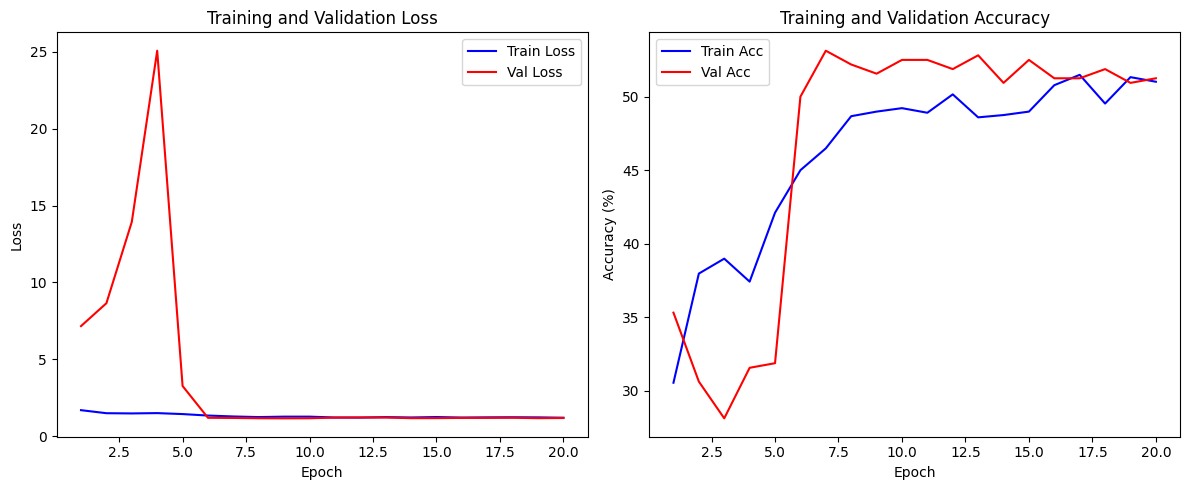

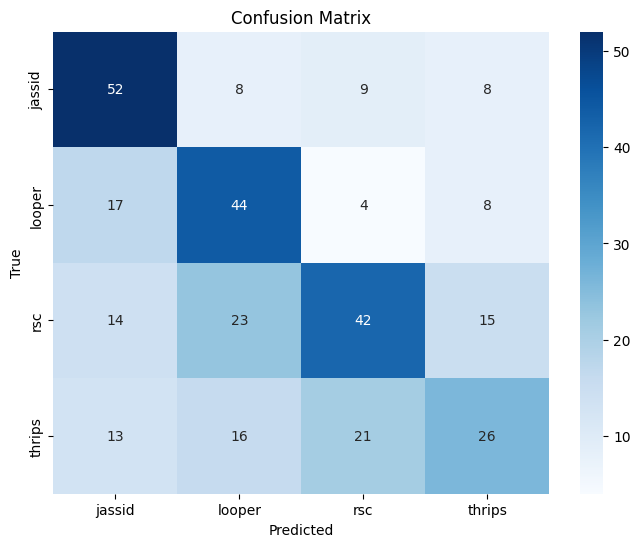


Classification Report:
              precision    recall  f1-score   support

      jassid       0.54      0.68      0.60        77
      looper       0.48      0.60      0.54        73
         rsc       0.55      0.45      0.49        94
      thrips       0.46      0.34      0.39        76

    accuracy                           0.51       320
   macro avg       0.51      0.52      0.51       320
weighted avg       0.51      0.51      0.51       320



/home/idrone2/.local/lib/python3.11/site-packages/torch/utils/checkpoint.py:551: UserWarning: torch.utils.checkpoint.checkpoint_sequential: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


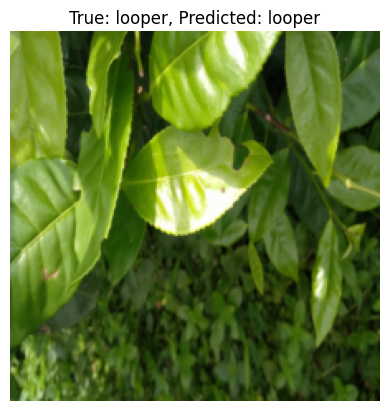

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
from torch.utils.checkpoint import checkpoint_sequential  # For gradient checkpointing
from torch.cuda.amp import GradScaler, autocast  # For mixed precision

class DarknetBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels, momentum=0.03)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels, momentum=0.03)
        self.leaky_relu = nn.LeakyReLU(0.1, inplace=False)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = x + residual
        return x

class Darknet50(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.03)
        self.leaky_relu = nn.LeakyReLU(0.1, inplace=False)
        
        # Simplified structure to reduce memory (capped at 1024 channels)
        self.layers = nn.ModuleList([
            # Stage 1: 64 -> 128
            self._make_layer(64, 128, num_blocks=1),
            # Stage 2: 128 -> 256
            self._make_layer(128, 256, num_blocks=2),
            # Stage 3: 256 -> 512
            self._make_layer(256, 512, num_blocks=8),
            # Stage 4: 512 -> 1024
            self._make_layer(512, 1024, num_blocks=8),
            # Stage 5: 1024 -> 1024 (reduced from 2048)
            self._make_layer(1024, 1024, num_blocks=4)
        ])
        
        # Single pooling to save memory
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(1024, num_classes)  # Reduced from 2048 * 2
        
        # Weight initialization
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, num_blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels, momentum=0.03))
        layers.append(nn.LeakyReLU(0.1, inplace=False))
        for _ in range(num_blocks):
            layers.append(DarknetBlock(out_channels))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        
        # Use checkpointing for layers
        for layer in self.layers:
            x = checkpoint_sequential(layer, segments=1, input=x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Data Loading and Preprocessing
def load_data(data_dir):
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=train_transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    val_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Reduced batch size
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    return train_loader, val_loader, dataset.classes

# Training Function with Mixed Precision
def train_model(model, train_loader, val_loader, num_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    scaler = GradScaler()  # For mixed precision training
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Mixed precision
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    return train_losses, val_losses, train_accs, val_accs, all_preds, all_labels

# Plotting Functions
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Acc')
    plt.plot(epochs, val_accs, 'r-', label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, all_preds, class_names):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Prediction on Random Image
def predict_random_image(model, dataset, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    image = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        with autocast():
            output = model(image)
            _, predicted = torch.max(output, 1)
    
    image = image.squeeze().cpu().permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
    
    plt.imshow(image)
    plt.title(f"True: {class_names[label]}, Predicted: {class_names[predicted.item()]}")
    plt.axis('off')
    plt.show()

# Main Execution
def main():
    data_dir = "/home/idrone2/Desktop/Camellia/tea_4_cls"
    train_loader, val_loader, class_names = load_data(data_dir)
    print(f"Classes: {class_names}")
    
    model = Darknet50(num_classes=4)
    
    train_losses, val_losses, train_accs, val_accs, all_preds, all_labels = train_model(model, train_loader, val_loader, num_epochs=20)
    
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
    plot_confusion_matrix(all_labels, all_preds, class_names)
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    full_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))
    predict_random_image(model, full_dataset, class_names)

if __name__ == "__main__":
    main()

Classes: ['jassid', 'looper', 'rsc', 'thrips']


/home/idrone2/.local/lib/python3.11/site-packages/torch/utils/checkpoint.py:551: UserWarning: torch.utils.checkpoint.checkpoint_sequential: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch [1/50], Train Loss: 35.0115, Train Acc: 25.08%, Val Loss: 1296.1734, Val Acc: 26.56%
Epoch [2/50], Train Loss: 12.0792, Train Acc: 26.56%, Val Loss: 59.9591, Val Acc: 26.25%
Epoch [3/50], Train Loss: 8.9854, Train Acc: 27.81%, Val Loss: 7.4217, Val Acc: 20.94%
Epoch [4/50], Train Loss: 7.1463, Train Acc: 27.19%, Val Loss: 9.6164, Val Acc: 29.38%
Epoch [5/50], Train Loss: 6.5130, Train Acc: 26.56%, Val Loss: 31.0193, Val Acc: 20.62%
Epoch [6/50], Train Loss: 6.6503, Train Acc: 28.05%, Val Loss: 11.6428, Val Acc: 29.38%
Epoch [7/50], Train Loss: 5.2687, Train Acc: 26.25%, Val Loss: 26.1900, Val Acc: 32.81%
Epoch [8/50], Train Loss: 4.4723, Train Acc: 27.58%, Val Loss: 8.9911, Val Acc: 24.06%
Epoch [9/50], Train Loss: 3.3292, Train Acc: 31.17%, Val Loss: nan, Val Acc: 34.38%
Epoch [10/50], Train Loss: 2.7601, Train Acc: 32.58%, Val Loss: nan, Val Acc: 28.44%
Epoch [11/50], Train Loss: 2.4866, Train Acc: 32.73%, Val Loss: nan, Val Acc: 36.56%
Epoch [12/50], Train Loss: 2.3871, Train 

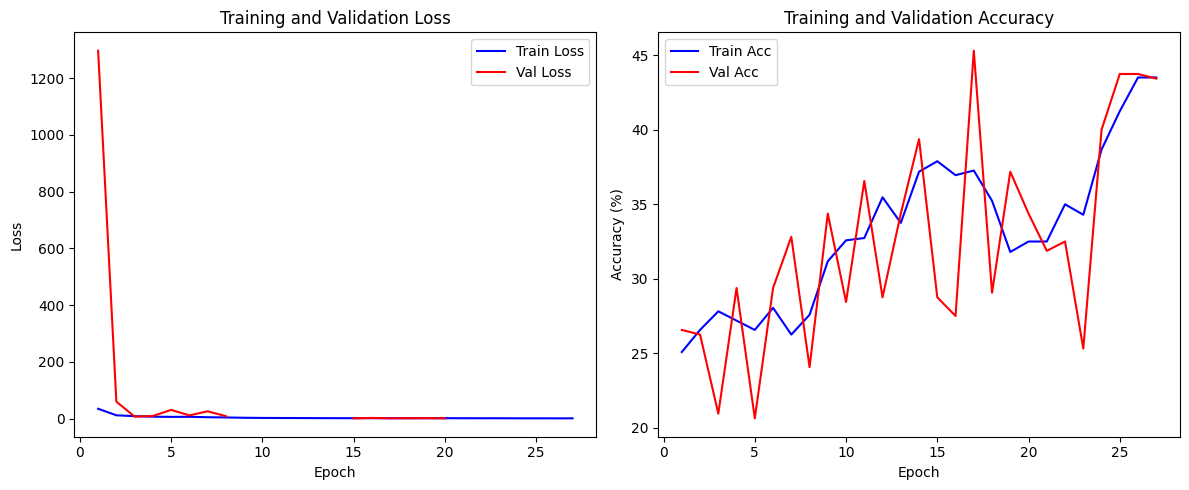

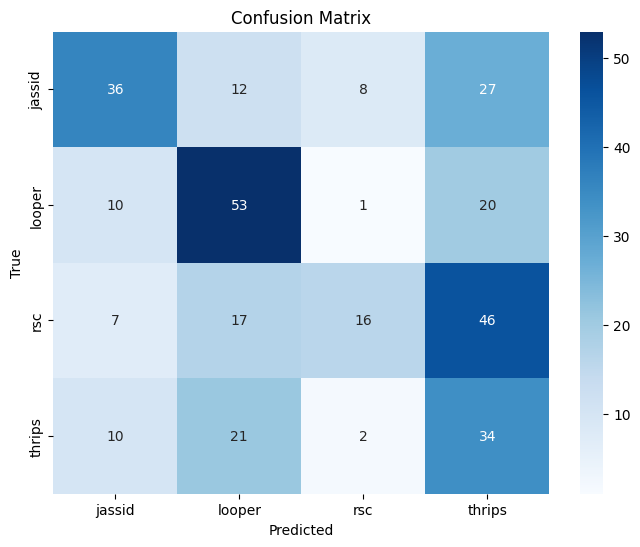


Classification Report:
              precision    recall  f1-score   support

      jassid       0.57      0.43      0.49        83
      looper       0.51      0.63      0.57        84
         rsc       0.59      0.19      0.28        86
      thrips       0.27      0.51      0.35        67

    accuracy                           0.43       320
   macro avg       0.49      0.44      0.42       320
weighted avg       0.50      0.43      0.43       320



/home/idrone2/.local/lib/python3.11/site-packages/torch/utils/checkpoint.py:551: UserWarning: torch.utils.checkpoint.checkpoint_sequential: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


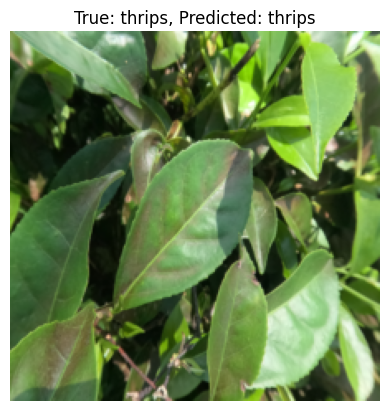

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
from torch.utils.checkpoint import checkpoint_sequential
from torch.cuda.amp import GradScaler, autocast

class DarknetBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels // 2, kernel_size=1, bias=False)  # Bottleneck design
        self.bn1 = nn.BatchNorm2d(channels // 2, momentum=0.03)
        self.conv2 = nn.Conv2d(channels // 2, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels, momentum=0.03)
        self.leaky_relu = nn.LeakyReLU(0.1, inplace=False)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = x + residual
        return x

class Darknet50(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1, bias=False)  # Increased initial channels
        self.bn1 = nn.BatchNorm2d(128, momentum=0.03)
        self.leaky_relu = nn.LeakyReLU(0.1, inplace=False)
        
        self.layers = nn.ModuleList([
            self._make_layer(128, 256, num_blocks=1),
            self._make_layer(256, 512, num_blocks=2),
            self._make_layer(512, 1024, num_blocks=8),
            self._make_layer(1024, 1024, num_blocks=8),
            self._make_layer(1024, 1024, num_blocks=4)
        ])
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)  # Reduced dropout
        self.fc1 = nn.Linear(1024, 512)  # Added classification head
        self.fc2 = nn.Linear(512, num_classes)
        
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, num_blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels, momentum=0.03))
        layers.append(nn.LeakyReLU(0.1, inplace=False))
        for _ in range(num_blocks):
            layers.append(DarknetBlock(out_channels))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        
        for layer in self.layers:
            x = checkpoint_sequential(layer, segments=1, input=x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Data Loading and Preprocessing
def load_data(data_dir):
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=train_transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    val_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    return train_loader, val_loader, dataset.classes

# Training Function with Class Weights and Early Stopping
def train_model(model, train_loader, val_loader, num_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Class weights to handle imbalance
    class_counts = [77, 73, 94, 76]  # From your support values
    class_weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)  # Increased weight decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    scaler = GradScaler()
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    patience = 10
    early_stop_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Scheduler and Early Stopping
        scheduler.step(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break
    
    return train_losses, val_losses, train_accs, val_accs, all_preds, all_labels

# Plotting Functions (unchanged)
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Acc')
    plt.plot(epochs, val_accs, 'r-', label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, all_preds, class_names):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def predict_random_image(model, dataset, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        with autocast():
            output = model(image)
            _, predicted = torch.max(output, 1)
    image = image.squeeze().cpu().permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
    plt.imshow(image)
    plt.title(f"True: {class_names[label]}, Predicted: {class_names[predicted.item()]}")
    plt.axis('off')
    plt.show()

# Main Execution
def main():
    data_dir = "/home/idrone2/Desktop/Camellia/tea_4_cls"
    train_loader, val_loader, class_names = load_data(data_dir)
    print(f"Classes: {class_names}")
    
    model = Darknet50(num_classes=4)
    train_losses, val_losses, train_accs, val_accs, all_preds, all_labels = train_model(model, train_loader, val_loader, num_epochs=50)
    
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
    plot_confusion_matrix(all_labels, all_preds, class_names)
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    full_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))
    predict_random_image(model, full_dataset, class_names)

if __name__ == "__main__":
    main()